In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.compat.v1.set_random_seed(0)
import matplotlib.pyplot as plt
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
from keras.optimizers import adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.utils import to_categorical
import csv
import pickle
cifar_image_path = 'cifar-10-batches-py'


#list of hyperparameters
# 1. learning rate
# 2. no of layers
# 3. optimization method
# 4. no of hidden units
# 5. dropout rate

#for testing purpose, only 1 and 5 selected

Using TensorFlow backend.


In [2]:
import optuna
from optuna.integration import KerasPruningCallback
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#function to load cifar-10 image-file (batch wise)
def load_cifar10_data(cifar_image_path, n_batch):
    
    features = []
    labels = []
    
    for batch_id in range(1, n_batch + 1):
        #'with open()'- opens the file 
        #f = open("path_to_file", mode='r+b') in reading + binary mode
        with open(cifar_image_path + '/data_batch_' + str(batch_id), mode='r+b') as file:
        
        
            #Module translates an in-memory Python object  
            #into a serialized byte stream—a string of  
            #bytes that can be written to any file-like object.
            #pickle.load - with filename
            #pickle.loads - without filename
            batch = pickle.load(file, encoding='latin1')
     
    
        for i in range(0, len(batch['labels'])):
        
            features.append(batch['data'][i])
            labels.append(batch['labels'][i])
    
    
    #divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
    #this results in (3 x 1024) dimension of tensor.
    #divide the resulting tensor from the previous step with 32. 32 here means width of an image.
    #this results in (3 x 32 x 32)    
    features = np.array(features)
    labels = np.array(labels)
    features = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1)
    
    
    #output is two arrays, first: feature matrix & second: label matrix
    return features, labels





#function to load cifar-10 test image-file
def load_cifar10_test_data(cifar_image_path):
    
    features = []
    labels = []
    
    with open(cifar_image_path + '/test_batch', mode='r+b') as file:
        
        batch = pickle.load(file, encoding='latin1')
     
    for i in range(0, len(batch['labels'])):
        
        features.append(batch['data'][i])
        labels.append(batch['labels'][i])
       
    features = np.array(features)
    labels = np.array(labels)
    features = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1)
    
    return features, labels
    

Shape of feature-matrix containing image-data is given below (no. of images x image-dims) :
(50000, 32, 32, 3)
7


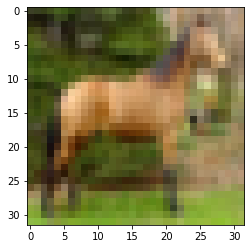

In [4]:
#loading images stored in 5 batches
features, labels = load_cifar10_data(cifar_image_path, 5)

print('Shape of feature-matrix containing image-data is given below (no. of images x image-dims) :')
print(features.shape)
plt.imshow(features[545])
print(labels[545])

features = []
labels = []

In [5]:
#function to define desired lables to assign images in the dataset
def load_label_names():
    
    #returns array of strings for each class-name
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']    

In [6]:
def create_model(trial):
    # dropout in each layer

    model = Sequential()   
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters", [32, 64]),
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu',
            input_shape=(32,32,3),
            )
        )  
    n_cnn = trial.suggest_int("n_cnn", 1, 3)
    if n_cnn > 0:
        num_filters1 = trial.suggest_categorical("n_filters_1", [32, 64])
        model.add(
            Conv2D(
            filters=num_filters1,
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu'
            )
        )
        if n_cnn > 1:
            num_filters2 = trial.suggest_categorical("n_filters_2", [64, 128])
            model.add(
                Conv2D(
                filters=num_filters2,
                kernel_size= (3,3),
                padding = 'same',
                activation= 'relu'
                )
            )
            if n_cnn > 2:
                num_filters3 = trial.suggest_categorical("n_filters_3", [64, 128])
                model.add(
                    Conv2D(
                    filters=num_filters3,
                    kernel_size= (3,3),
                    padding = 'same',
                    activation= 'relu'
                    )
                )    
                    
    model.add(MaxPooling2D(pool_size=(2,2)))   
    model.add(Flatten())
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    
    if n_layers > 0:
        num_hidden1 = trial.suggest_categorical("n_units_1", [128, 256, 512, 1024, 2048])
        model.add(Dense(num_hidden1, activation="relu"))
        dropout1 = trial.suggest_uniform("dropout_1", 0.1, 0.3)
        model.add(Dropout(rate=dropout1))
        if n_layers > 1:
            num_hidden2 = trial.suggest_categorical("n_units_2", [128, 256, 512, 1024, 2048])
            model.add(Dense(num_hidden2, activation="relu"))
            dropout2 = trial.suggest_uniform("dropout_2", 0.1, 0.3)
            model.add(Dropout(rate=dropout2))
            if n_layers > 2:
                num_hidden3 = trial.suggest_categorical("n_units_3", [128, 256, 512, 1024, 2048])
                model.add(Dense(num_hidden3, activation="relu"))
                dropout3 = trial.suggest_uniform("dropout_3", 0.1, 0.3)
                model.add(Dropout(rate=dropout3))
    
    model.add(Dense(10, activation="softmax"))

    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)    
    
    opt = SGD(lr = lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [7]:
def objective(trial):
    
    # clear clutter from previous session graphs.
    tf.keras.backend.clear_session()
    
    training_images, training_labels = load_cifar10_data(cifar_image_path, 5)
    training_images = training_images/255.0
    
    test_images, test_labels = load_cifar10_test_data(cifar_image_path)
    test_images = test_images/255.0

    print('Not using data augmentation.')
    
    # Generate our trial model.
    model = create_model(trial)
    
    # Fit the model on the training data.
    # The KerasPruningCallback checks for pruning condition every epoch.
    history = model.fit(training_images, training_labels, 
              callbacks=[KerasPruningCallback(trial, "val_acc")],
              epochs=15,
              validation_split = 0.1, verbose = 2)
    

    # Evaluate the model accuracy on the test set.
    score = model.evaluate(test_images, test_labels, verbose=0)
    print ('Test loss: {}, Test accuracy: {}'.format(score[0], score[1]*100.0))
    return score[1]


In [8]:
sampler = optuna.integration.CmaEsSampler()
#sampler = optuna.samplers.TPESampler(seed = 0)
study = optuna.create_study(sampler = sampler, direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)
#sampler = optuna.integration.CmaEsSampler(seed = 0)
#study.optimize(objective, n_trials=20)
pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:38:28,830] Finished trial#0 resulted in value: 0.15299999713897705. Current best value is 0.15299999713897705 with parameters: {'filters': 64, 'n_cnn': 2, 'n_filters_1': 64, 'n_filters_2': 128, 'n_layers': 3, 'n_units_1': 512, 'dropout_1': 0.251948701730914, 'n_units_2': 256, 'dropout_2': 0.13597244738697667, 'n_units_3': 512, 'dropout_3': 0.15980717318482326, 'lr': 1.6414373580898427e-05}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:41:05,309] Finished trial#1 resulted in value: 0.40849998593330383. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:43:38,670] Finished trial#2 resulted in value: 0.38690000772476196. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:46:13,735] Finished trial#3 resulted in value: 0.40290001034736633. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:48:48,613] Finished trial#4 resulted in value: 0.3813999891281128. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:51:22,936] Finished trial#5 resulted in value: 0.40119999647140503. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:53:56,195] Finished trial#6 resulted in value: 0.40380001068115234. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:56:31,346] Finished trial#7 resulted in value: 0.3968000113964081. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 20:59:09,295] Finished trial#8 resulted in value: 0.39739999175071716. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:01:47,692] Finished trial#9 resulted in value: 0.3993000090122223. Current best value is 0.40849998593330383 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.20651684687645117, 'n_units_2': 512, 'dropout_2': 0.19997495958751976, 'lr': 0.0002977403762944276}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:04:25,060] Finished trial#10 resulted in value: 0.41999998688697815. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:07:05,272] Finished trial#11 resulted in value: 0.4009000062942505. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:09:45,018] Finished trial#12 resulted in value: 0.39399999380111694. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:12:22,809] Finished trial#13 resulted in value: 0.4043999910354614. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:14:59,631] Finished trial#14 resulted in value: 0.38609999418258667. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:17:36,390] Finished trial#15 resulted in value: 0.39579999446868896. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:20:14,297] Finished trial#16 resulted in value: 0.3962000012397766. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:22:50,521] Finished trial#17 resulted in value: 0.4000999927520752. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:25:27,677] Finished trial#18 resulted in value: 0.4108999967575073. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:28:02,707] Finished trial#19 resulted in value: 0.39739999175071716. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:30:40,344] Finished trial#20 resulted in value: 0.40630000829696655. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:33:19,276] Finished trial#21 resulted in value: 0.3946000039577484. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:35:54,830] Finished trial#22 resulted in value: 0.4092999994754791. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:38:29,835] Finished trial#23 resulted in value: 0.4032999873161316. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:41:08,419] Finished trial#24 resulted in value: 0.4032999873161316. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:43:43,249] Finished trial#25 resulted in value: 0.41929998993873596. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:46:21,141] Finished trial#26 resulted in value: 0.39989998936653137. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:48:57,570] Finished trial#27 resulted in value: 0.39309999346733093. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:51:37,015] Finished trial#28 resulted in value: 0.4146000146865845. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:54:12,740] Finished trial#29 resulted in value: 0.41819998621940613. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:56:50,044] Finished trial#30 resulted in value: 0.4156999886035919. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 21:59:25,116] Finished trial#31 resulted in value: 0.4163999855518341. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:02:04,329] Finished trial#32 resulted in value: 0.4077000021934509. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:04:41,417] Finished trial#33 resulted in value: 0.41440001130104065. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:07:17,211] Finished trial#34 resulted in value: 0.4106000065803528. Current best value is 0.41999998688697815 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.18011846116179545, 'n_units_2': 512, 'dropout_2': 0.2255823687215757, 'lr': 0.00032007508102017317}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:09:55,178] Finished trial#35 resulted in value: 0.4316999912261963. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:12:32,947] Finished trial#36 resulted in value: 0.4059999883174896. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:15:12,007] Finished trial#37 resulted in value: 0.42829999327659607. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:17:51,139] Finished trial#38 resulted in value: 0.3833000063896179. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:20:28,002] Finished trial#39 resulted in value: 0.42329999804496765. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:23:04,684] Finished trial#40 resulted in value: 0.4153999984264374. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:25:42,948] Finished trial#41 resulted in value: 0.3971000015735626. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:28:20,498] Finished trial#42 resulted in value: 0.41370001435279846. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:30:52,531] Finished trial#43 resulted in value: 0.41440001130104065. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:33:24,608] Finished trial#44 resulted in value: 0.4196000099182129. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:35:54,943] Finished trial#45 resulted in value: 0.4187000095844269. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:38:26,960] Finished trial#46 resulted in value: 0.41449999809265137. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:40:58,990] Finished trial#47 resulted in value: 0.41510000824928284. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:43:30,148] Finished trial#48 resulted in value: 0.4068000018596649. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-05 22:46:00,323] Finished trial#49 resulted in value: 0.41370001435279846. Current best value is 0.4316999912261963 with parameters: {'filters': 32, 'n_cnn': 2, 'n_filters_1': 32, 'n_filters_2': 64, 'n_layers': 2, 'n_units_1': 512, 'dropout_1': 0.1862146789144615, 'n_units_2': 512, 'dropout_2': 0.2125091894120892, 'lr': 0.00031722873588031075}.


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  0.4316999912261963
  Params: 
    filters: 32
    n_cnn: 2
    n_filters_1: 32
    n_filters_2: 64
    n_layers: 2
    n_units_1: 512
    dropout_1: 0.1862146789144615
    n_units_2: 512
    dropout_2: 0.2125091894120892
    lr: 0.00031722873588031075


In [9]:
with open("Optuna_result_CIFAR10_dict_CMAES.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Results"])
    for trial in study.trials:
        writer.writerow([trial.value])

In [10]:
for i in range(50):
    print(study.trials[i].value)

0.15299999713897705
0.40849998593330383
0.38690000772476196
0.40290001034736633
0.3813999891281128
0.40119999647140503
0.40380001068115234
0.3968000113964081
0.39739999175071716
0.3993000090122223
0.41999998688697815
0.4009000062942505
0.39399999380111694
0.4043999910354614
0.38609999418258667
0.39579999446868896
0.3962000012397766
0.4000999927520752
0.4108999967575073
0.39739999175071716
0.40630000829696655
0.3946000039577484
0.4092999994754791
0.4032999873161316
0.4032999873161316
0.41929998993873596
0.39989998936653137
0.39309999346733093
0.4146000146865845
0.41819998621940613
0.4156999886035919
0.4163999855518341
0.4077000021934509
0.41440001130104065
0.4106000065803528
0.4316999912261963
0.4059999883174896
0.42829999327659607
0.3833000063896179
0.42329999804496765
0.4153999984264374
0.3971000015735626
0.41370001435279846
0.41440001130104065
0.4196000099182129
0.4187000095844269
0.41449999809265137
0.41510000824928284
0.4068000018596649
0.41370001435279846


In [14]:
print("  Value: ", study.best_trial.value)

print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))
    

  Value:  0.4316999912261963
  Params: 
    filters: 32
    n_cnn: 2
    n_filters_1: 32
    n_filters_2: 64
    n_layers: 2
    n_units_1: 512
    dropout_1: 0.1862146789144615
    n_units_2: 512
    dropout_2: 0.2125091894120892
    lr: 0.00031722873588031075
